In [1]:
import os   #used for directory work
import matplotlib.pyplot as plt #used for creating plots
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
def text_finder(path):
    txt_files=[]
    all_files = os.listdir(path) #tells what directory the files are in
    for i in all_files: #reading only the .txt files 
        if i[-4:] == ".txt":
            txt_files.append(i)
    txt_files.sort() #alphabetizes them
    
    return txt_files

def file_to_df(path):
    df= pd.read_csv(path,na_values = ['NAN', "00nan"], sep=" ")
    
    return df

In [4]:
def quad_averages(quad_list, t_s, t_e ):            
    ###Finding the sums of the quadriants 
    cut_quad_list = list(quad_list[t_s:t_e])

    Q1, Q2 = cut_quad_list.count(1), cut_quad_list.count(2)
    Q3, Q4 = cut_quad_list.count(3), cut_quad_list.count(4)
    
    nan = cut_quad_list.count(0)        
    Q_sum = Q1 + Q2 + Q3 + Q4
    
    if Q_sum != 0: 
        Qlst_ave = [Q1/Q_sum, Q2/Q_sum, Q3/Q_sum, Q4/Q_sum]
    if Q_sum == 0:
        Qlst_ave = [0, 0, 0, 0]
    
    return Qlst_ave


def fire_start(df,n):    
    ### Finding the start of fire
    x_fire, fire_5sig = 9e10, np.nanmean(df["T"])+5*np.std(df["T"]) 
    for i in range(n, len(df["T"])):
        if df["T"][i] > fire_5sig:
            x_fire = i
            break
    
    return x_fire


def sonic_calculations(df, n, x_fire):
    ### pre-burn averaging index
    pre_brn_start, pre_brn_end = 0, n
    if n > 9000:
        pre_brn_start = n - 9000 #Making the pre-burn period max time of 30 min
    
    pre_brn_len = pre_brn_end - pre_brn_start
    #print(pre_brn_start,pre_brn_end)
    
    ### Getting the pre-fire averages
    W_mean = np.nanmean(df["W"][pre_brn_start:pre_brn_end])
    T_mean = np.nanmean(df["T"][pre_brn_start:pre_brn_end])
    
    ### Creating te Prime Lists
    
    W_prime, T_prime= list(np.full(len(df),np.nan)),list(np.full(len(df),np.nan))
    for i in range(len(df)):
        W_prime[i] = df["W"][i] - W_mean
        T_prime[i] = df["T"][i] - T_mean
    
    wt_prime_list = list(np.full(len(df),np.nan))
    for i in range(len(df)):
        wt_prime_list[i] = W_prime[i]*T_prime[i]
    
    ### Pulling the quadriants out of the lists    
    quad_list = list(np.full(len(df),0)) 
    for i in range(len(df)):
        #quad_mag.append(abs(W_prime[i]*T_prime[i]))
        if float(W_prime[i]) > 0 and float(T_prime[i]) > 0:
            quad_list[i] = 1
            continue
        if float(W_prime[i]) > 0 and float(T_prime[i]) < 0:
            quad_list[i] = 2
            continue
        if float(W_prime[i]) < 0 and float(T_prime[i]) < 0:
            quad_list[i] = 3
            continue
        if float(W_prime[i]) < 0 and float(T_prime[i]) > 0:
            quad_list[i] = 4
            continue
            
    ### W'T' pre-burn averages
    pre_wt_prime_ave = np.nanmean(wt_prime_list[pre_brn_start:pre_brn_end])
    
    pre_Qlst = quad_averages(quad_list, pre_brn_start, pre_brn_end)

    ### Fire calculations
    brn_n = len(wt_prime_list[x_fire:])
    
    #30mins = 18000 15mins = 9000 10mins = 6000 5mins = 3000
    fire_end = len(df)-1 #the end of the fire period 
    if brn_n > 9000:
        fire_end = x_fire + 9000 #30mins after the fire
        brn_n = len(wt_prime_list[x_fire:fire_end])

    brn_wt_prime_ave = np.nanmean(wt_prime_list[x_fire:fire_end])
    brn_Qlst = quad_averages(quad_list, x_fire, fire_end)
    
    return pre_Qlst, pre_wt_prime_ave, pre_brn_len, brn_Qlst, brn_wt_prime_ave, brn_n
    
def burn_calculations(path, n):
    txt_files = text_finder(path)
    
    ### Load in the DF and find the begining of the fire of all sonics
    df_list, x_fire_lst = [], []
    for i in range(16):
        df = file_to_df(path + txt_files[i])
        x_fire_lst.append(fire_start(df,n))
        df_list.append(df)

    n_fire = min(x_fire_lst)
    burn_timestamp =df_list[-1]["TIMESTAMP"][n_fire]
    #print(n_fire,df_list[-1]["TIMESTAMP"][n_fire])
    pre_burn_Q_lst, burn_Q_lst= [], []
    pre_WT_ave, brn_WT_ave = [],[]
    brn_n_lst= []
    for i in range(16):
        pre_Qlst, pre_wt_prime_ave, pre_brn_len, brn_Qlst,\
            brn_wt_prime_ave, brn_n = sonic_calculations(df_list[i],n, n_fire)
        
        pre_burn_Q_lst.append(pre_Qlst)
        pre_WT_ave.append(pre_wt_prime_ave)
        brn_WT_ave.append(brn_wt_prime_ave)
        burn_Q_lst.append(brn_Qlst)
        brn_n_lst.append(brn_n)
    
    brn_len_min = []
    for i in range(len(brn_n_lst)):
        brn_len_min.append(brn_n_lst[i]/(600))
        
    return pre_burn_Q_lst, burn_Q_lst,  pre_WT_ave, brn_WT_ave, x_fire_lst, n_fire, brn_n_lst,\
            brn_len_min, pre_brn_len, burn_timestamp
    

Now on Burn:  01
Now on Burn:  02
Now on Burn:  03
Now on Burn:  04
Now on Burn:  05
Now on Burn:  06
Now on Burn:  07
Now on Burn:  08


/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


Now on Burn:  09
Now on Burn:  11
Now on Burn:  12
Now on Burn:  13
Now on Burn:  18
Now on Burn:  19
Now on Burn:  20
Now on Burn:  21
Now on Burn:  22
Now on Burn:  23
Now on Burn:  24
Now on Burn:  25
Now on Burn:  26
Now on Burn:  27
Now on Burn:  28
Now on Burn:  29
Now on Burn:  30
Now on Burn:  31
Now on Burn:  32
Now on Burn:  33
CPU times: user 8min 23s, sys: 2.12 s, total: 8min 25s
Wall time: 8min 25s


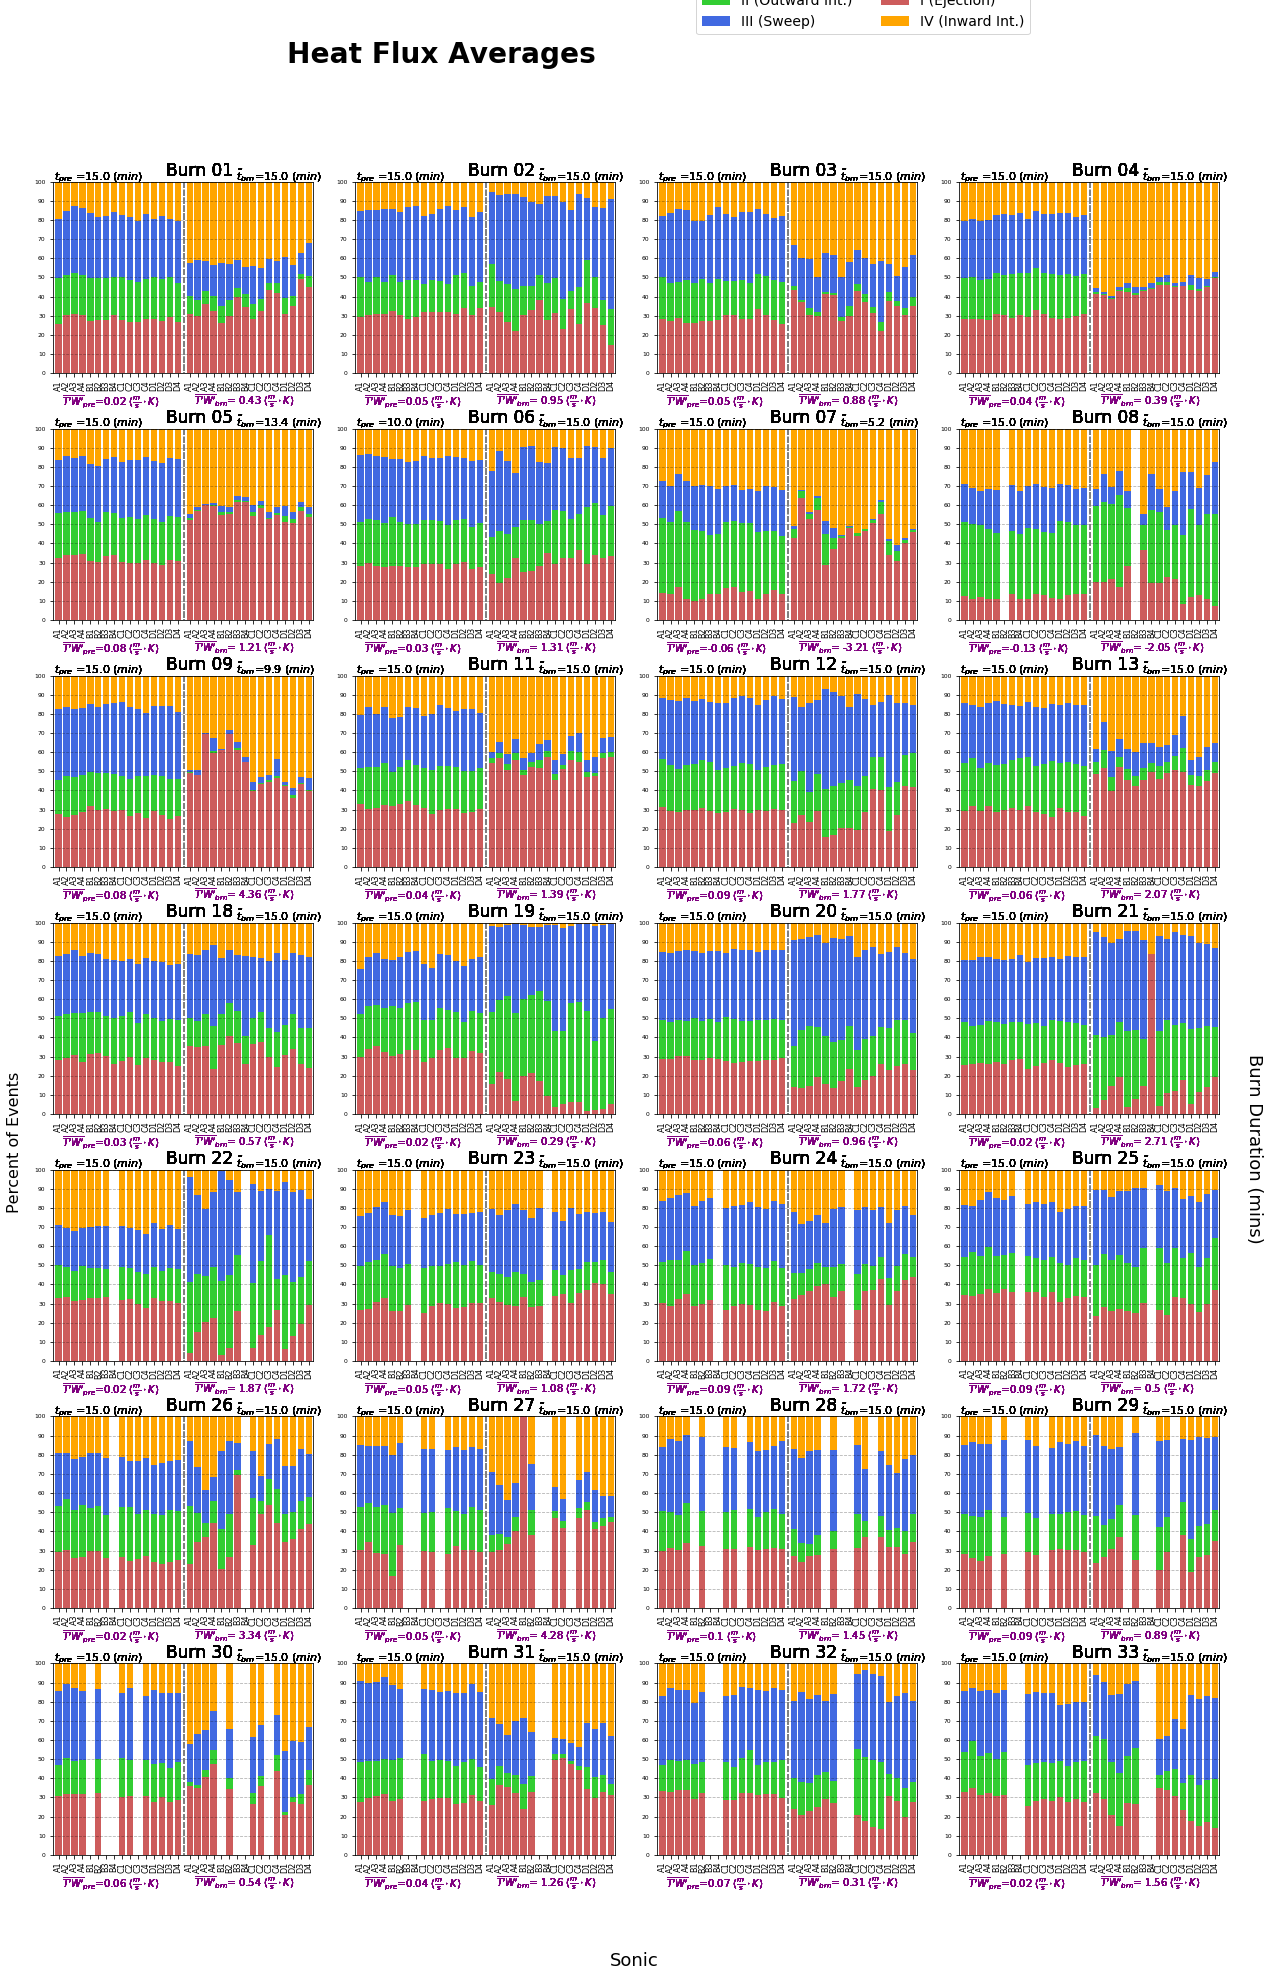

In [5]:
%%time
#path = "/home/JoeySeitz/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-"
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-"#79
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-" #w10
path_end = "/sonics/"
burns = ["01","02","03","04","05","06","07","08","09","11","12","13","18","19","20", \
         "21","22","23","24","25","26","27", "28","29","30","31","32","33","34"]
burn_d = {'01': 21000, '02': 14000, '03': 20000, '04': 30000, '05': 15000, \
          '06': 6000, '07': 25000, '08': 18000, '09': 20000, '11': 30000,  \
          '12': 60000, '13': 50000, '18': 185000, '19': 45000, '20': 24000,\
          '21': 25000, '22': 27000, '23': 45000, '24': 20000, '25': 25000, \
          '26': 25000, '27': 35000, '28': 27000, '29': 25000, '30': 12000, \
          '31': 30000, '32': 25000, '33': 20000, '34': 40000}

### Plotting stuff 
sonic_list = ["A1","A2","A3","A4", "B1","B2", "B3", "B4", "C1", "C2","C3", "C4", "D1", "D2", "D3", "D4"]*2
x_loc_1= list(np.arange(1,17,1))
x_loc_2 = list(np.arange (17.5,33,1))
x_loc = x_loc_1 + x_loc_2

y_loc =np.arange(0.0,1.1,0.1)
y_tick_names  = np.arange(0,110,10)
fig, ax = plt.subplots(nrows=7,ncols=4,figsize=(18,28))#, sharey=True)
Burn_timestamps =[]
### Keep out of loop
file_count = 0
for col in range(7):
    for row in range(4):
        burn_path= str(path + str(burns[file_count])+path_end)
        print("Now on Burn: ",str(burns[file_count]))
        pre_burn_Q_lst, burn_Q_lst,  pre_WT_ave, brn_WT_ave, x_fire_lst, n_fire, brn_n_lst,\
            brn_len_min, pre_brn_len, burn_timestamp= burn_calculations(burn_path, burn_d[burns[file_count]])
        Burn_timestamps.append(burn_timestamp)
        #print(brn_n_lst)
        axs = ax[ col, row]
        
        x1, x2 = 1, 17.5
        for i in range(16):
            axs.bar(x1, pre_burn_Q_lst[i][1],label = "II (Outward Int.)",color = "limegreen", bottom=pre_burn_Q_lst[i][0])
            axs.bar(x1, pre_burn_Q_lst[i][2],label = "III (Sweep)",color ="royalblue", bottom=pre_burn_Q_lst[i][0]+pre_burn_Q_lst[i][1])
            axs.bar(x1, pre_burn_Q_lst[i][0],label = "I (Ejection)",color="indianred")
            axs.bar(x1, pre_burn_Q_lst[i][3],label = "IV (Inward Int.)",color = "orange",  bottom=pre_burn_Q_lst[i][0]+pre_burn_Q_lst[i][1]+pre_burn_Q_lst[i][2])

            axs.bar(x2, burn_Q_lst[i][1],label = "II (Outward Int.)",color = "limegreen", bottom=burn_Q_lst[i][0])
            axs.bar(x2, burn_Q_lst[i][2],label = "III (Sweep)",color ="royalblue", bottom=burn_Q_lst[i][0]+burn_Q_lst[i][1])
            axs.bar(x2, burn_Q_lst[i][0],label = "I (Ejection)",color="indianred")
            axs.bar(x2, burn_Q_lst[i][3],label = "IV (Inward Int.)",color = "orange",  bottom=burn_Q_lst[i][0]+burn_Q_lst[i][1]+burn_Q_lst[i][2])

            axs.vlines(16.75,1,0, linestyle = "--", color = "grey")#alpha = .7)
            #axs.vlines(33.25,1,0, linestyle = "--",color = "grey")
            axs.set_ylim(0,1)
            axs.set_xlim(.25,33)
            axs.yaxis.grid(linestyle='--', color = "k", alpha = .3)
            axs.set_yticks(y_loc) 
            axs.set_yticklabels(y_tick_names, fontsize = 6)


            #axs.set_title("Pre-Burn Period"+"  "*35+ "Burn Period", fontsize = 16, x = .2)
            #axs.set_ylabel("Percent of Events", fontsize = 10)
            #axs.set_xlabel("Sonic", fontsize = 18, x=.47)
            pre_txt = r" ${t}_{pre}$ ="+str(round(pre_brn_len/600,1))+" $(min)$"
            brn_txt =r" $\tilde{t}_{brn}$="+str(round(np.median(brn_len_min),1))+" $(min)$"
            axs.text(14.5,1.03, "Burn "+str(burns[file_count]), fontsize = 17)
            
            axs.text(23,1.01,brn_txt, fontsize = 11, weight = "light"  )
            axs.text(0,1.01,pre_txt, fontsize = 11, weight = "light" )

            axs.text(1,-.17," $\overline{T{}'W{}'}_{pre}$=" + str(round(np.nanmean(pre_WT_ave), 2))+ r" ($\frac{m}{s} \cdot {K}$)" , fontsize = 10, color = "purple")
            axs.text(18,-.17, "$\overline{T{}'W{}'}_{brn}$= " + str(round(np.nanmean(brn_WT_ave), 2))+ r" ($\frac{m}{s} \cdot {K}$)", fontsize = 10, color = "purple")

            #axs2 = axs.twinx()
            #axs2.boxplot(brn_len_min,widths=1, positions = [34.25])

            #axs2.set_yticks(axs2_ytic_loc)
            #axs2.tick_params(axis="y", labelsize=6)
            #for i in range(len(brn_len_min)):
            #    if brn_len_min[i]> np.median(brn_len_min)+stats.iqr(brn_len_min)*1.5 or \
            #        brn_len_min[i]<np.median(brn_len_min)-stats.iqr(brn_len_min)*1.5:

            #       axs2.text(35.25, brn_len_min[i], sonic_list[i],fontsize=6, weight = "light", color = "b")

            axs.set_xticks(x_loc)
            axs.set_xticklabels(sonic_list, fontsize=8,rotation='vertical')   
      
            x1 += 1
            x2 += 1
        file_count += 1 
    
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:4], labels[:4], ncol = 2, fontsize = 14, bbox_to_anchor=(.8, .99), framealpha = .8)
fig.suptitle("Heat Flux Averages", fontsize = 28, y = .97, x = .35, fontweight = "bold")
fig.text(0.015,0.39,"Percent of Events", rotation  = 90, fontsize = 16)
fig.text(0.97, 0.375,"Burn Duration (mins)", rotation = 270, fontsize = 18)
fig.text(0.48,0.015, "Sonic", fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(hspace=0.29,wspace=0.16, top=0.9, left = 0.05, right = .95, bottom = .07)

fig.savefig("rough_aveplot_15min-15min.png", dpi = 350)
### Took 56mins and 45s to run on W10 Desktop
## Took 1hr 17min to run on 134
###New time of 15min 4s!!!(134 at 30min)

In [11]:
for i in range(len(Burn_timestamps)):
    print(burns[i],":", Burn_timestamps[i][11:])

01 : 14:09:37.400
02 : 11:29:24.100
03 : 13:27:40.500
04 : 10:53:28.200
05 : 12:42:35.900
06 : 14:44:27.500
07 : 11:02:00.700
08 : 12:52:30.400
09 : 10:51:31.100
11 : 09:42:28.800
12 : 12:01:05.000
13 : 14:12:10.500
18 : 14:26:15.200
19 : 16:47:18.900
20 : 14:26:16.400
21 : 16:10:29.800
22 : 17:55:46.000
23 : 12:14:04.300
24 : 14:07:13.500
25 : 15:46:51.800
26 : 17:23:43.000
27 : 10:49:09.800
28 : 12:28:07.400
29 : 14:17:16.800
30 : 15:18:35.600
31 : 10:51:44.700
32 : 12:53:49.500
33 : 16:08:49.500


In [ ]:
n_list = [21000,14000,20000,30000,15000,6000,25000,18000,30000,60000,50000,185000,45000,24000,25000,27000,\
         45000,20000,25000,25000,35000,27000,25000,12000,30000,25000,20000,40000]

In [15]:
n = 15000

In [19]:
pre_brn_end

15000

In [13]:
burn_path= str(path + "34"+path_end)
pre_burn_Q_lst, burn_Q_lst,  pre_WT_ave, brn_WT_ave, x_fire_lst, n_fire, brn_n_lst,\
            brn_len_min, pre_brn_len, burn_timestamp= burn_calculations(burn_path, 40000)

/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


In [14]:
print(burn_timestamp)

2019-05-31 11:12:50.300


In [68]:
min(x_fire_lst)

25860

In [86]:
d = {}
for i in range(len(n_list)):
    d[burns[i]]= n_list[i]

print(d)

{'01': 21000, '02': 14000, '03': 20000, '04': 30000, '05': 15000, '06': 6000, '07': 25000, '08': 18000, '09': 20000, '11': 30000, '12': 60000, '13': 50000, '18': 185000, '19': 45000, '20': 24000, '21': 25000, '22': 27000, '23': 45000, '24': 20000, '25': 25000, '26': 25000, '27': 35000, '28': 27000, '29': 25000, '30': 12000, '31': 30000, '32': 25000, '33': 20000, '34': 40000}


In [82]:
n_list = [21000,14000,20000,30000,15000,6000,25000,18000,20000,30000,60000,50000,185000,45000,24000,25000,27000,\
         45000,20000,25000,25000,35000,27000,25000,12000,30000,25000,20000,40000]
burns = ["01","02","03","04","05","06","07","08","09","11","12","13","18","19","20", \
         "21","22","23","24","25","26","27", "28","29","30","31","32","33","34"]

In [91]:
d["01"]

21000